# Will it Turing?

We model the spreading of signals as diffusion. However, the accuarcy of this model is questionable at least since cytonemes have been connected with most singalling pathways. Furthermore synthetic biologists prefer using cell-cell communication, since there are no orthogonal diffusible molecules available and agent-based models often approximate diffusion by cell-cell communication. Therefore it is important to understand what the essence of diffusion in biology is.

Here we start from ideal diffusion and see how far we can move towards a signal spreading by cell-cell communication to still get proper gradients and Turing pattern.

In [1]:
from functools import partial

import numpy as np
from scipy.integrate import solve_ivp
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('paper', font_scale=1.4)

More specifically, we look at coupled ODEs, representing either a discretized circle or a ring of cells. We then solve the morphogen gradient
$$ \dot c = D \tilde\Delta c - d\cdot c$$
with $c(t, 0) = 1$ and the linearized substrate depletion model (Miura & Maini, 2004)
$$ 
\begin{eqnarray*}
\dot u & = & 0.5u + 0.6v - u^3 + 2\tilde\Delta u \\
\dot v & = & -1.9u - 2v + 25\tilde\Delta v 
\end{eqnarray*}$$
for different non-local couplings $\tilde\Delta$, e.g. a finite difference scheme for Fick's law.

In [2]:
x = np.arange(0, 101, 1)


D = 0.1
d = 0.01

def source(coupling, _, c):
    dcdt = D*coupling(c) - d*c
    dcdt[0] = 0
    return dcdt
    
    
offset = 1

def turing(coupling, _, uv):
#     assert (uv > 0).all()
    u = uv[:101]
    v = uv[101:]

    dudt = 0.5*(u - offset) + 0.6*(v - offset) - (u - offset)**3 + 2*coupling(u)
    dvdt = -1.9*(u - offset) - 2*(v - offset) + 25*coupling(v)
    return np.append(dudt, dvdt)


def test_diffusion_model(coupling):
    """Plot gradient from source and Turing pattern"""
    plt.figure(figsize=(12, 3))

    analytic_gradient = np.exp(-np.sqrt(d/D)*x)
    c_0 = np.append(1, np.zeros(len(x) - 1))
    c = solve_ivp(partial(source, coupling), [0, 1e3], c_0, 'BDF')

    plt.subplot2grid(shape=(1, 4), loc=(0, 0))
    plt.plot(x[:26], analytic_gradient[:26], 'k')
    plt.plot(x[:26], c.y[:, -1][:26], 'ko')
    plt.legend(['Exponential', coupling.description], frameon=False)
    plt.xlabel('Space')
    plt.xlim([-1, 26])
    plt.ylabel('Concentration')
    plt.yticks([])

    uv_0 = offset + np.random.rand(len(x)*2)/100
    uv = solve_ivp(partial(turing, coupling), [0, 1e3], uv_0, 'BDF')

    plt.subplot2grid(shape=(1, 4), loc=(0, 1), colspan=3)
    plt.plot(x, uv.y[:, -1][101:], 'ko')
    plt.xlabel('Space')
    plt.xlim([-1, 101])
    plt.yticks([0, offset], ['', '$u_0$'])

    sns.despine()
    plt.tight_layout()
    plt.savefig(coupling.description.replace(' ', '_').replace("'", '').replace('.', '') + '.png', 
                dpi=300)
    plt.show()

## Fick's Law

We can discretize Fick's law $\vec j = \nabla c$ as $\Delta c_i = (c_{i - 1} - c_i) + (c_{i + 1} - c_i)$.

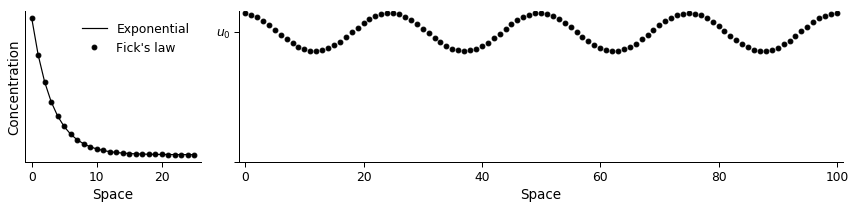

In [3]:
def ficks_law(u):
    """Finite difference scheme for Fick's law"""
    lapl = np.empty(len(u))
    lapl[0] = u[-1] - 2*u[0] + u[1]
    lapl[1:-1] = u[:-2] - 2*u[1:-1] + u[2:]
    lapl[-1] = u[-2] - 2*u[-1] + u[0]
    return lapl


ficks_law.description = "Fick's law"
test_diffusion_model(ficks_law)

## Porous Medium

In porous media the flux is $\vec j = c\cdot\nabla c$ and thus $\tilde \Delta c = \nabla (c\cdot \nabla c) = (\nabla c)^2 + c\Delta c$.

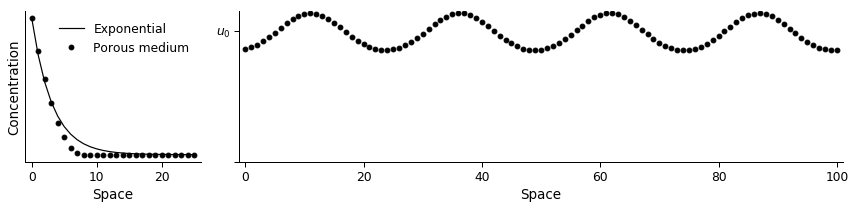

In [37]:
def porous_diff(u):
    """Finite difference scheme for porous medium with m = 1"""
    grad = np.empty(len(u))
    grad[0] = (u[-1] - u[1])/2
    grad[1:-1] = (u[:-2] - u[2:])/2
    grad[-1] = (u[-2] - u[0])/2
    
    lapl = np.empty(len(u))
    lapl[0] = u[-1] - 2*u[0] + u[1]
    lapl[1:-1] = u[:-2] - 2*u[1:-1] + u[2:]
    lapl[-1] = u[-2] - 2*u[-1] + u[0]

    return (grad*grad + u*lapl)


porous_diff.description = 'Porous medium'
test_diffusion_model(porous_diff)

## Polarized Tissue

In this hypothetical tissue diffusion towards the left is altered, i.e. $\tilde \Delta c \propto (c_{i - 1} - c_i) + r(c_{i + 1} - c_i)$.

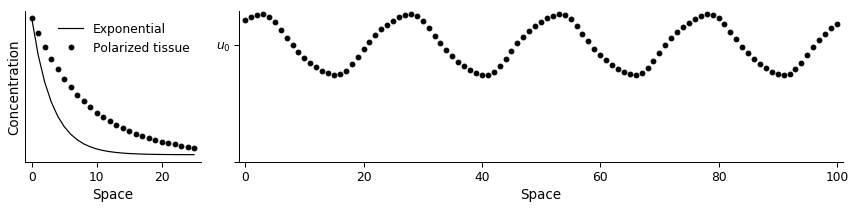

In [36]:
def asymmetric_diffusion(u):
    r = 0
    diff = np.empty(len(u))
    diff[0] = u[-1] - (1 + r)*u[0] + u[1]*r
    diff[1:-1] = u[:-2] - (1 + r)*u[1:-1] + u[2:]*r
    diff[-1] = u[-2] - (1 + r)*u[-1] + u[0]*r
    return diff/1.25


asymmetric_diffusion.description = 'Polarized tissue'
test_diffusion_model(asymmetric_diffusion)

## Cytoneme Transport

Here $\tilde \Delta c \propto (c_{i - r} - c_i) + (c_{i + s} - c_i)$ where $r$ and $s$ are poisson distributed, resulting in each cell having two outgoing and two incoming edges, but one cell can have input on more (or less) than two edges.

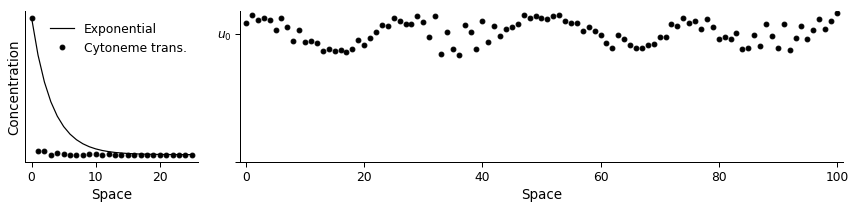

In [6]:
left = np.remainder(np.arange(len(x)) - np.random.poisson(3, len(x)), len(x))
right = np.remainder(np.arange(len(x)) + np.random.poisson(3, len(x)), len(x))

def cytoneme_transport(u):
    diff = u[left] - 2*u + u[right]
    return diff/7


cytoneme_transport.description = 'Cytoneme trans.'
test_diffusion_model(cytoneme_transport)

Accounting for the outflow of the actual outgoing edges breaks the Turing pattern, and making sure each cell is the input of exactly two other cells restores it:

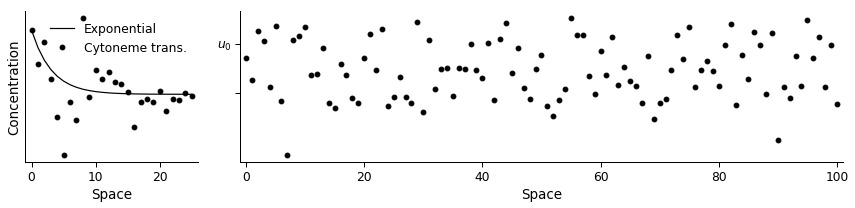

In [7]:
left = np.remainder(np.arange(len(x)) - np.random.poisson(3, len(x)), len(x))
right = np.remainder(np.arange(len(x)) + np.random.poisson(3, len(x)), len(x))

def cytoneme_transport(u):
    diff = u[left] + u[right]
    np.add.at(diff, left, -u)
    np.add.at(diff, right, -u)
    return diff/3


cytoneme_transport.description = 'Cytoneme trans.'
test_diffusion_model(cytoneme_transport)

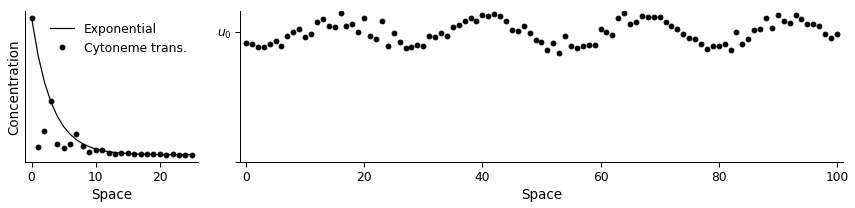

In [35]:
# def mean_dist(indices):
#     l = len(indices)
#     dists = np.arange(l) - indices
#     dists[dists < 0] += l
#     return np.mean(dists)

left = np.remainder(np.arange(len(x)) - 3, len(x))
right = np.remainder(np.arange(len(x)) + 3, len(x))
for _ in range(100):
    l = len(left)
    i = np.random.randint(0, l)
    j = np.remainder(i+1, l)
    left[[i, j]] = left[[j, i]]
    i = np.random.randint(0, l)
    j = np.remainder(i+1, l)
    right[[i, j]] = right[[j, i]]


def cytoneme_transport(u):
    diff = u[left] - 2*u + u[right]
    return diff/7


cytoneme_transport.description = 'Cytoneme trans.'
test_diffusion_model(cytoneme_transport)

## Cell-cell Communication

Cells do not loose material when communicating with their neighbours, i.e. $\require{cancel} \tilde \Delta c \propto (c_{i - 1} - \cancel{c_i}) + (c_{i + 1} - \cancel{c_i})$

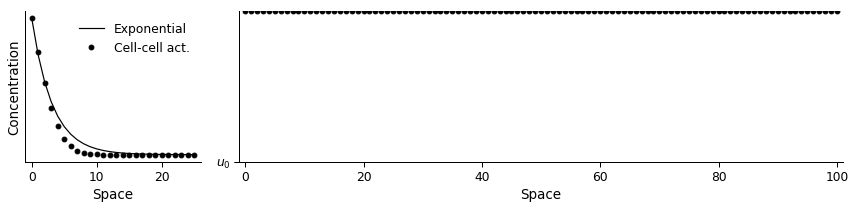

In [9]:
def cell_cell_act(u):
    diff = np.empty(len(u))
    diff[0] = u[-1] + u[1]
    diff[1:-1] = u[:-2] + u[2:]
    diff[-1] = u[-2] + u[0]
    return diff/20


cell_cell_act.description = 'Cell-cell act.'
test_diffusion_model(cell_cell_act)

## Timescales

For the wavelength $L \propto \sqrt{D/\gamma}$.

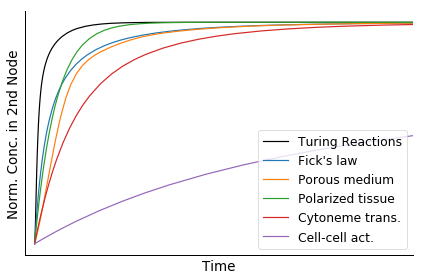

In [10]:
def no_coupling(_):
    return 0


uv_0 = 0.01 + np.random.rand(len(x)*2)/100
uv = solve_ivp(partial(turing, no_coupling), [0, 1e3], uv_0, 'BDF')

plt.xlabel('Time')
plt.ylabel('Norm. Conc. in 2nd Node')
plt.xticks([])
plt.yticks([])
plt.plot(uv.t, uv.y[1], 'k', label='Turing Reactions')

couplings = [ficks_law, porous_diff, asymmetric_diffusion, 
             cytoneme_transport, cell_cell_act]

for i, coupling in enumerate(couplings):
    c_0 = np.append(1, np.zeros(len(x) - 1))
    c = solve_ivp(partial(source, coupling), [0, 1e5], c_0, 'BDF')
    plt.plot(c.t, c.y[1]/np.max(c.y[1]), label=coupling.description)

plt.xlim([-5, 200])
plt.legend()
sns.despine()
plt.tight_layout()
plt.savefig('time.png', dpi=300)
plt.show()

## Conservation of Mass

/home/germann/Software/anaconda/lib/python3.6/site-packages/scipy/integrate/_ivp/bdf.py:418: RuntimeWarning: divide by zero encountered in power
  factors = error_norms ** (-1 / np.arange(order, order + 3))


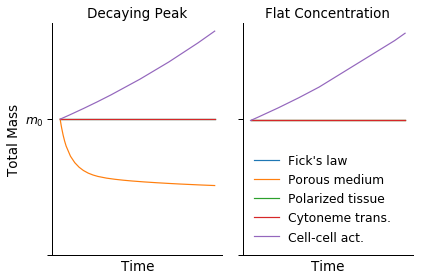

In [39]:
def diffusion(coupling, _, c):
    return coupling(c)


_, axs = plt.subplots(1, 2, sharex=True, sharey=True)

peak_0 = np.zeros(len(x))
peak_0[int(len(x)/2)] = 1

flat_0 = np.ones(len(x))/len(x)

for i, c_0 in enumerate([peak_0, flat_0]):
    axs[i].set_xlabel('Time')
    axs[i].set_xticks([])
    for coupling in couplings:
        c = solve_ivp(partial(diffusion, coupling), [0, 5], c_0, 'BDF')
        axs[i].plot(c.t, np.trapz(c.y.T), label=coupling.description)

axs[0].set_title('Decaying Peak')
axs[0].set_ylabel('Total Mass')
axs[0].set_ylim(ymin=0)
axs[1].set_title('Flat Concentration')
axs[1].legend(frameon=False)
plt.yticks([0, 1], ['', '$m_0$'])

sns.despine()
plt.tight_layout()
plt.savefig('mass.png', dpi=300)
plt.show()

/home/germann/Software/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:3157: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


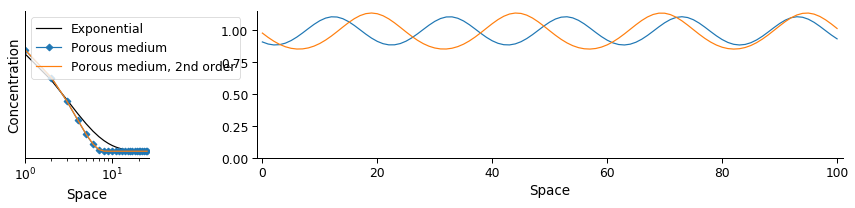

In [12]:
def porous_diff_2ndorder(u):
    """Finite difference scheme for porous medium with m = 1"""
    lapl = np.empty(len(u))
    lapl[0] = u[-1]**2 - 2*u[0]**2 + u[1]**2
    lapl[1:-1] = u[:-2]**2 - 2*u[1:-1]**2 + u[2:]**2
    lapl[-1] = u[-2]**2 - 2*u[-1]**2 + u[0]**2
    return lapl/2

porous_diff_2ndorder.description = 'Porous medium, 2nd order'


plt.figure(figsize=(12, 3))
analytic_gradient = np.exp(-np.sqrt(d/D)*x)
grad_ax = plt.subplot2grid(shape=(1, 4), loc=(0, 0))
grad_ax.semilogx(x[:26], analytic_gradient[:26], 'k')
turing_ax = plt.subplot2grid(shape=(1, 4), loc=(0, 1), colspan=3)

styles = ('D', '')
for i, coupling in enumerate((porous_diff, porous_diff_2ndorder)):
    c_0 = np.append(1, np.zeros(len(x) - 1))
    c = solve_ivp(partial(source, coupling), [0, 1e3], c_0, 'BDF')
    grad_ax.semilogx(x[:26], c.y[:, -1][:26], marker=styles[i])

    uv_0 = offset + np.random.rand(len(x)*2)/100
    uv = solve_ivp(partial(turing, coupling), [0, 1e3], uv_0, 'BDF')
    turing_ax.plot(x, uv.y[:, -1][101:])

grad_ax.legend(['Exponential', porous_diff.description, porous_diff_2ndorder.description])
grad_ax.set_xlabel('Space')
grad_ax.set_xlim([-1, 26])
grad_ax.set_ylabel('Concentration')
grad_ax.set_yticks([])

turing_ax.set_xlabel('Space')
turing_ax.set_xlim([-1, 101])
turing_ax.set_yticks([0, offset], ['', '$u_0$'])
    
sns.despine()
plt.tight_layout()
plt.show()

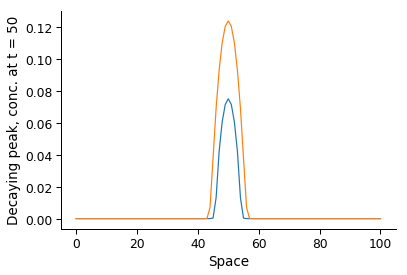

In [13]:
for coupling in (porous_diff, porous_diff_2ndorder):
    c = solve_ivp(partial(diffusion, coupling), [0, 50], peak_0, 'BDF')
    plt.plot(x, c.y.T[-1], label=coupling.description)

# plt.title('Decaying Peak')
plt.xlabel('Space')
plt.ylabel('Decaying peak, conc. at t = 50')
# plt.legend()
sns.despine()
plt.show()

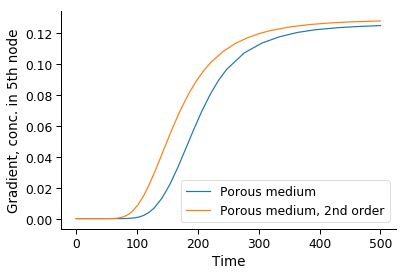

In [14]:
for coupling in (porous_diff, porous_diff_2ndorder):
    c = solve_ivp(partial(source, coupling), [0, 500], np.append(1, np.zeros(len(x) - 1)), 'BDF')
    plt.plot(c.t, c.y[5], label=coupling.description)

plt.legend()
plt.xlabel('Time')
plt.ylabel('Gradient, conc. in 5th node')
sns.despine()
plt.show()

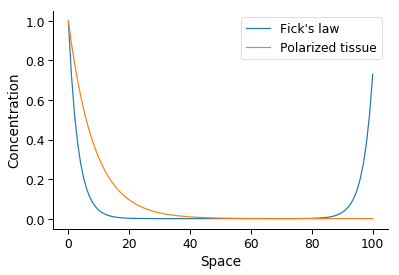

In [15]:
for coupling in (ficks_law, asymmetric_diffusion):
    c_0 = np.append(1, np.zeros(len(x) - 1))
    c = solve_ivp(partial(source, coupling), [0, 1e3], c_0, 'BDF')
    plt.plot(x, c.y.T[-1], label=coupling.description)

# plt.title('Decaying Peak')
plt.xlabel('Space')
plt.ylabel('Concentration')
plt.legend()
sns.despine()
plt.show()